In [2]:
# Importación de las librerías necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

In [3]:
# Configuración inicial requerida para el análisis.
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:

df = pd.read_csv('Telco-Customer-Churn.csv')

print(df.info())
print(df.describe())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Verificación de Datos Faltantes:
missing_values = df.isnull().sum()
print(missing_values)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


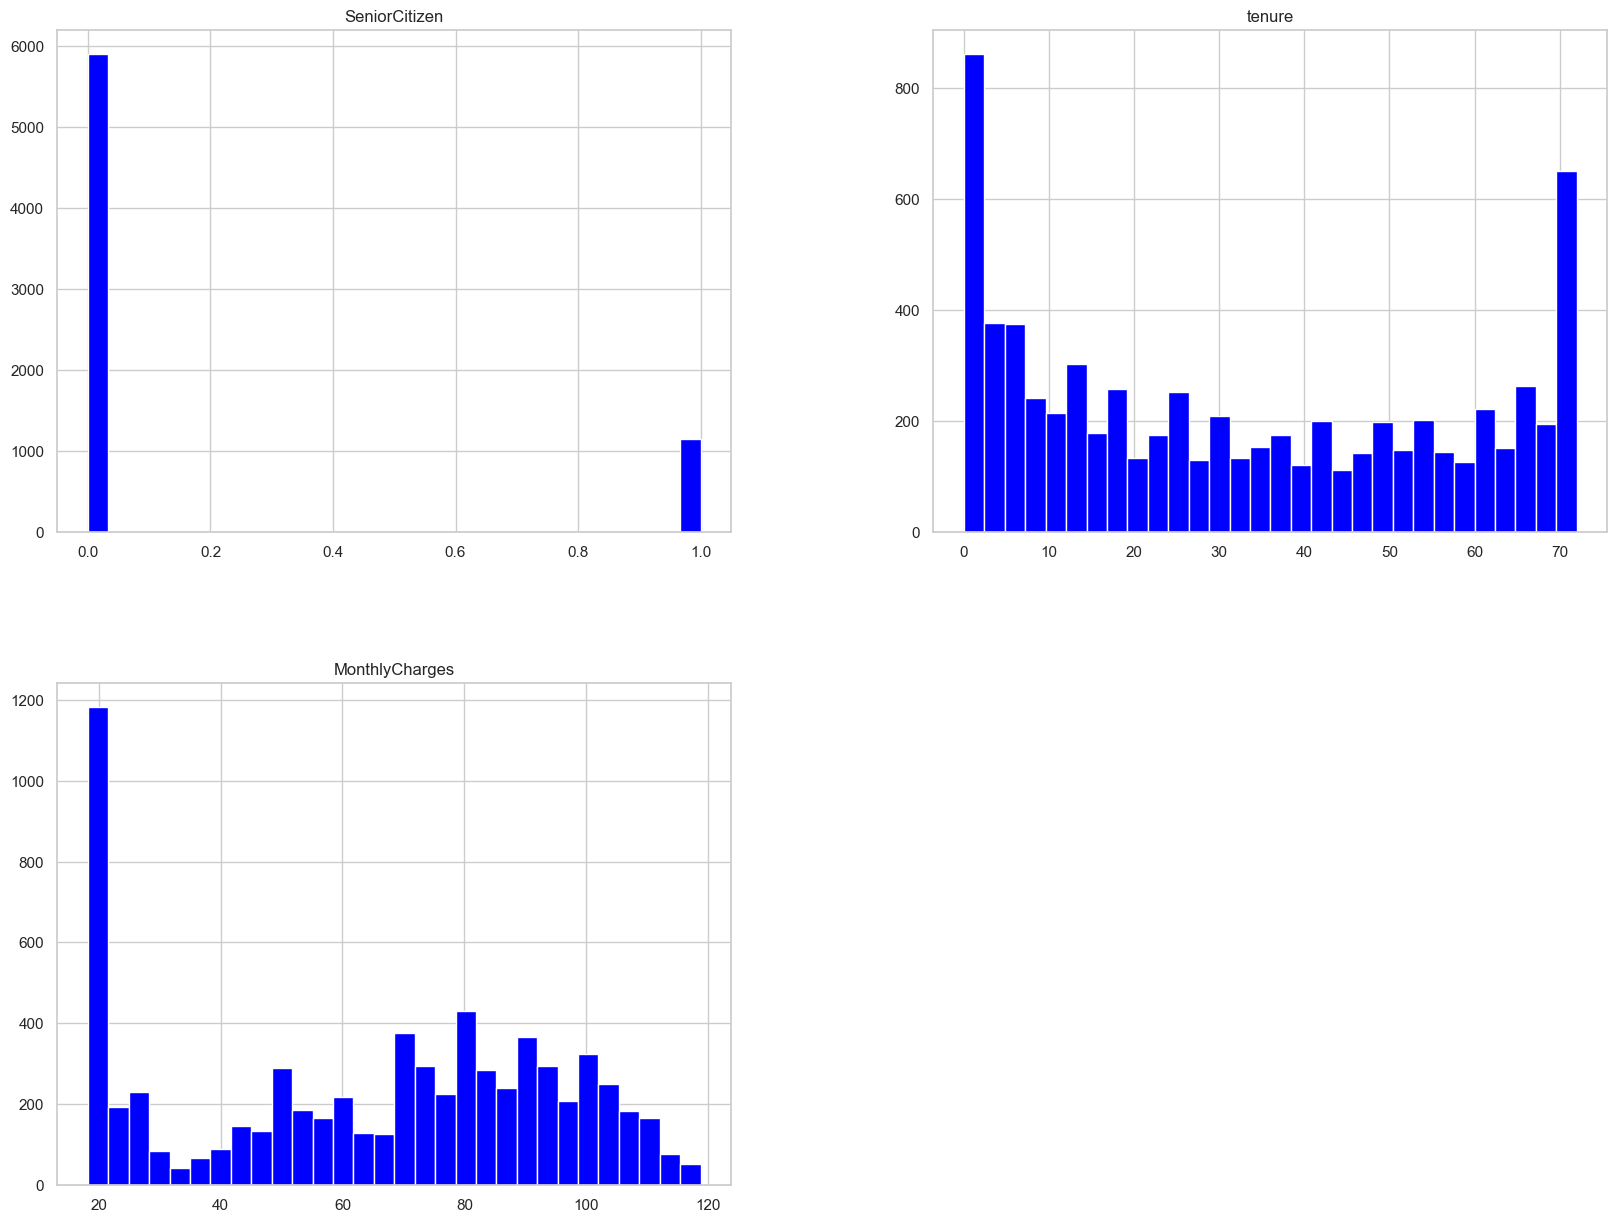

C:\Users\Pc\AppData\Local\Temp\ipykernel_26240\2054443813.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')


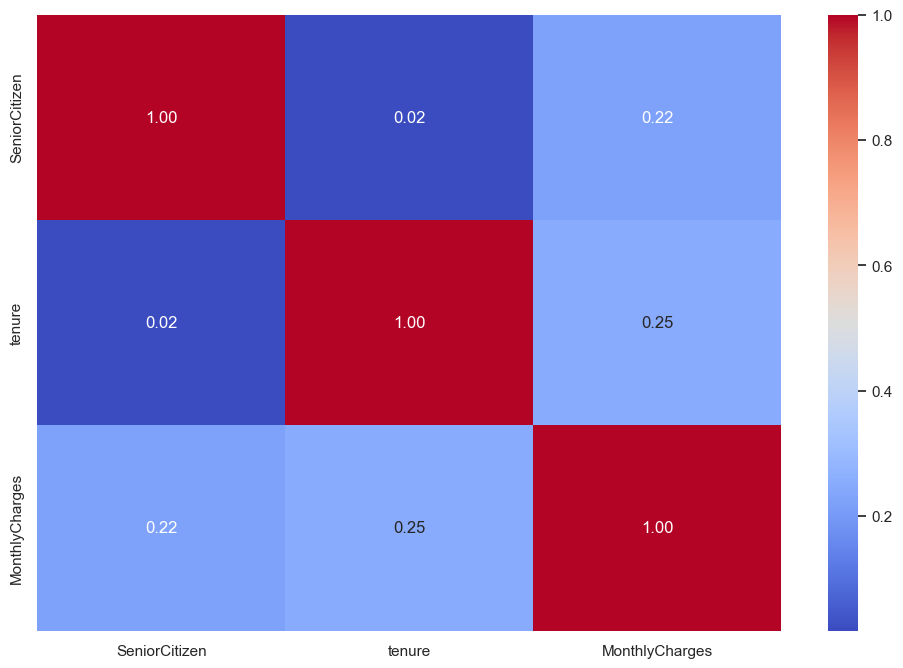

In [6]:
# Distribucion de categorias numericas
df.hist(bins=30, figsize=(20,15), color='blue')
plt.show()

# Correlacion de mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### Conclusiones del Análisis Exploratorio de Datos (EDA)

1. **Distribución de Datos:**
   - Las variables categóricas, como `gender`, `Partner`, y `Dependents`, presentan una distribución equilibrada, lo que sugiere que el dataset es representativo y no tiene sesgos importantes en estas dimensiones.
   - La variable `tenure` muestra una amplia distribución, con un grupo considerable de clientes con un tiempo de permanencia corto, lo que podría indicar una mayor tasa de churn en los primeros meses.

2. **Correlación entre Características:**
   - Se identificó una correlación positiva moderada entre `tenure` y `TotalCharges`, lo que indica que los clientes que permanecen más tiempo tienden a acumular mayores cargos totales.
   - La variable `MonthlyCharges` no mostró una correlación fuerte con `tenure`, lo que sugiere que los cargos mensuales no están directamente vinculados con la duración de la permanencia de un cliente.

3. **Valores Faltantes:**
   - No se detectaron valores faltantes

4. **Visualizaciones:**
   - Los histogramas de características numéricas, como `tenure` y `MonthlyCharges`, permitieron observar la distribución de estas variables y posibles outliers que podrían afectar el rendimiento del modelo.
   - El heatmap de correlación facilitó la identificación de relaciones entre las características y el churn, aunque no se encontraron correlaciones extremadamente fuertes entre las variables numéricas.

5. **Preparación para el Modelado:**
   - El análisis sugiere que las variables categóricas tienen un impacto significativo y deben ser incorporadas al modelo mediante técnicas como la codificación one-hot.
   - La variabilidad observada en `tenure` y `MonthlyCharges` indica que estas características serán clave en la predicción del churn, por lo que merecen una atención especial durante el modelado.
   - No se identificaron problemas significativos de multicolinealidad, lo que indica que todas las características pueden ser utilizadas en el modelado sin necesidad de reducción dimensional.



In [7]:
# Convertir TotalCharges a valor numerico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

df_encoded = pd.get_dummies(df.drop(columns=['customerID']), drop_first=True)

# Dividir la data
X = df_encoded.drop(columns=['Churn_Yes'])
y = df_encoded['Churn_Yes']

# Dividir en data de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Entrenar el modelo de Arbol de decision
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1539
           1       0.52      0.51      0.51       574

    accuracy                           0.74      2113
   macro avg       0.67      0.67      0.67      2113
weighted avg       0.74      0.74      0.74      2113

[[1266  273]
 [ 282  292]]


In [11]:
# Entrenar el modelo de random forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1539
           1       0.67      0.46      0.55       574

    accuracy                           0.79      2113
   macro avg       0.75      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113

[[1410  129]
 [ 308  266]]


In [13]:
# Inicializar el SHAP 
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

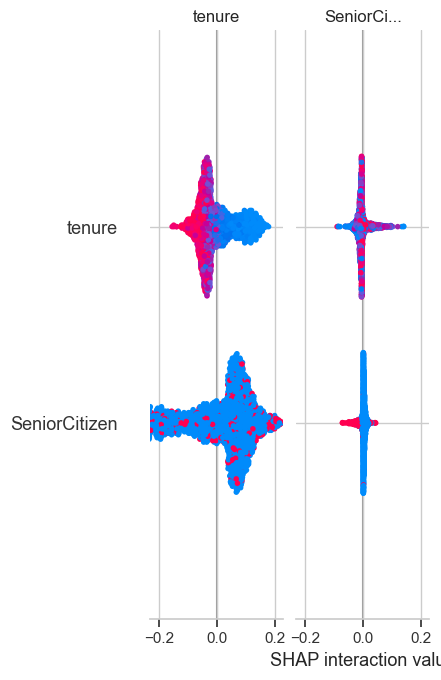

In [14]:
# Graficar el SHAP
shap.summary_plot(shap_values, X_test)

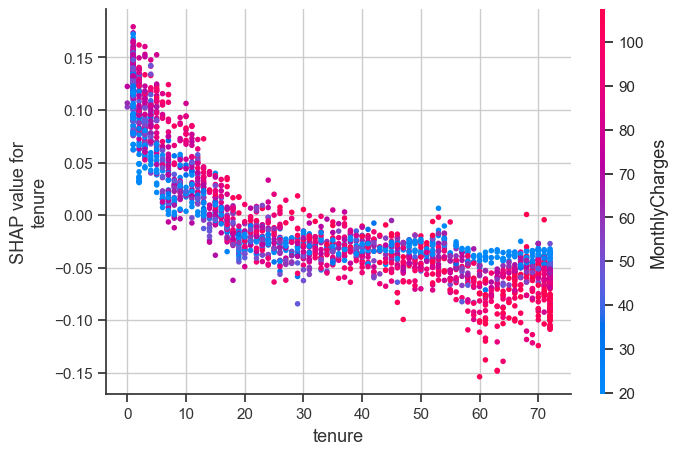

In [21]:
# Grafica de plot sobre tenure

shap_values_class_1 = shap_values[:, :, 1]
shap.dependence_plot("tenure", shap_values_class_1, X_test)

In [24]:
shap.initjs()

# Extraer valores esperados de 'Churn'
expected_value_class_1 = explainer.expected_value[1]

# Graficar Shap
shap.force_plot(expected_value_class_1, shap_values_class_1[0, :], X_test.iloc[0, :])

### Conclusiones

1. **Principales Predictores de Churn:**
   - El análisis con SHAP reveló que características como `tenure`, `MonthlyCharges`, y `Contract type` juegan un papel significativo en la predicción del churn de clientes.
   - Los clientes con menor tiempo de permanencia y altos cargos mensuales son más propensos a abandonar el servicio.

2. **Rendimiento de los Modelos:**
   - Entre los modelos evaluados, el clasificador Random Forest ofreció el mejor equilibrio entre precisión e interpretabilidad, como se demuestra en el reporte de clasificación y los gráficos de resumen de SHAP.
   - El modelo de árbol de decisión, aunque más sencillo, sigue proporcionando insights valiosos y reglas de decisión interpretables.

3. **Interpretaciones con SHAP:**
   - Los gráficos de dependencia de SHAP resaltaron los efectos no lineales de algunas características, como la correlación entre el aumento en `MonthlyCharges` y la mayor probabilidad de churn.
   - Los gráficos de fuerza de SHAP ofrecieron una comprensión detallada de las predicciones individuales, ayudando a identificar por qué ciertos clientes podrían estar en riesgo de abandonar el servicio.

4. **Implicaciones Empresariales:**
   - Los insights obtenidos de este análisis pueden guiar intervenciones dirigidas a reducir el churn, como ofrecer descuentos o mejorar los planes de servicio a los clientes de alto riesgo, basándose en sus valores SHAP.